In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from scipy.interpolate import interp1d
import datetime as dt
import os
from dieboldmariano import dm_test
%matplotlib inline

# Data

In [2]:
##############################################################################################################
#IMPORTANT: write the directory where the file 'FBFitted.csv', which contains the data, is located in your PC:
##############################################################################################################

file_path = "C:\\Users\\Franco\\Desktop\\project numerical\\FBFitted.csv"

In [3]:
df = pd.read_csv(file_path,index_col=0)

df.index = pd.to_datetime(df.index, format='%Y%m%d')

df = df.drop('1',axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Franco\\Desktop\\project numerical\\FBFitted.csv'

In [ ]:
#now we select from 1985 onwards:
start_idx = df.index.get_loc(dt.datetime.strptime('1985-01-31', '%Y-%m-%d'))
df = df.iloc[start_idx:]

#get the columns (will use it later)
columns = np.array(df.columns)

df.head()

# Loadings

In [ ]:
#define the loadings
lam = 0.0609
load2 = lambda x: (1.-np.exp(-lam*x)) / (lam*x)
load3 = lambda x: ((1.-np.exp(-lam*x)) / (lam*x)) - np.exp(-lam*x)

In [ ]:
#time to maturity, int version of df.columns
time_to_mat = np.array([3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 48, 60, 72, 84, 96, 108, 120])

In [ ]:
#setup the matrix with the beta values
X = np.empty([len(time_to_mat), 3])
X[:,0] = np.ones(len(time_to_mat))
X[:,1] = load2(time_to_mat)
X[:,2] = load3(time_to_mat)

## Figure 1

In [ ]:
#plot loadings against maturities

fig,ax = plt.subplots(figsize = (7, 5))

ax.plot(time_to_mat, X[:,0], label=r'$\beta_1$',linestyle = '--',color = 'r', alpha = 0.6)
ax.plot(time_to_mat, X[:,1], label=r'$\beta_2$',color = 'b', alpha = 0.6)
ax.scatter(time_to_mat, X[:,2], label=r'$\beta_3$',marker = '.', color = 'g', alpha = 0.6)

ax.set_title('Factor Loadings for Diebold Li Model')
ax.set_xlabel('Maturity (Months)')
ax.set_ylabel('Factor Loadings')

ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)

ax.legend()

#plt.savefig('figure1.png')
plt.show()

## 3D plot (figure 2)

In [9]:
#transform the variable inorder to 3d plot:
y = df.columns
y = y.astype(int)

#to solve the problem of having dates
x = df.index
x = [date.toordinal() for date in x]   #trasform dates into ordinals
x = np.array(x)
x = x.astype(int)
x = x[::-1]

x, y = np.meshgrid(y, x)    #create the mesh. I don't know why but in order to match the shape
                            #it's necessary to invert x and y. Since I spent a lot of time trying to understand
                            #how to make this 3D plot, I will ignore this issue.
z = df.values

In [10]:
#retrieve the dates to write in the label:
equidistant_dates = np.linspace(df.index[0].timestamp(), df.index[len(df)-1].timestamp(), 6)

#convert back to datetime objects
dates_labels = [dt.datetime.fromtimestamp(timestamp) for timestamp in equidistant_dates]
#remove the hours
dates_labels = [dates_labels[i].strftime('%Y-%m-%d') for i in range(len(dates_labels))]


#gettin the ordinal number
first_column_y = y[:,0]

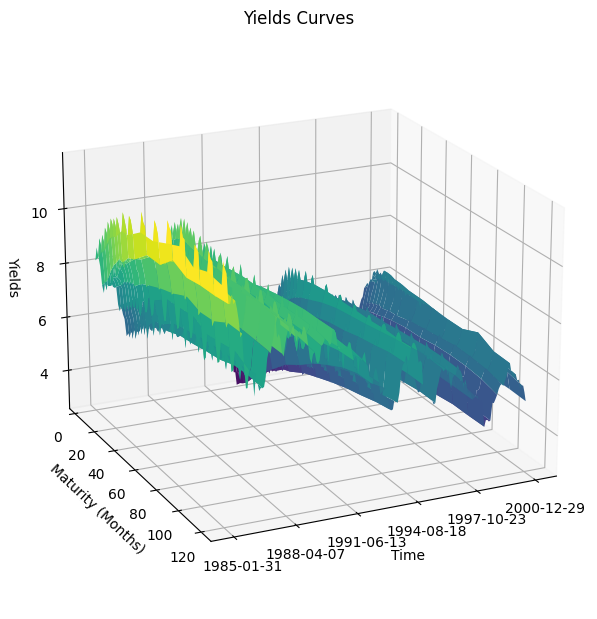

In [11]:
# Create 3D plot
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(y, x, z, cmap='viridis')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Maturity (Months)')
ax.set_zlabel('Yields')
ax.set_title('Yields Curves')

#ax.set_xticklabels([])
xticks = np.linspace(first_column_y[0], first_column_y[len(first_column_y)-1], 6)
ax.set_xticks(xticks, labels=dates_labels)

# Set the view angle
ax.view_init(elev=20, azim=65)  

#plt.savefig('figure2.png')
# Show plot
plt.show()

# Descriptive statistics of the data (Table1)

In [12]:
#add slope and curvature columns to the data frame
slope = df['120'] - df['3']
curvature = 2*df['24'] - (df['3'] + df['120'])

df1 = pd.merge(df, pd.DataFrame(slope), left_index=True, right_index=True)
df1 = pd.merge(df1, pd.DataFrame(curvature), left_index=True, right_index=True)

In [13]:
#change the names of the level slope and curvature of the new df
df1 = df1.rename(columns = {'120' : '120 (level)', '0_x' : 'Slope', '0_y' : 'Curvature'})
df1.head()

,3,6,9,12,15,18,21,24,30,36,48,60,72,84,96,108,120 (level),Slope,Curvature
Date,,,,,,,,,,,,,,,,,,,
1985-01-31,8.241,8.433,8.698,8.844,9.165,9.477,9.632,9.689,10.089,10.110,10.555,10.590,10.862,11.115,10.744,10.957,10.878,2.637,0.259
1985-02-28,8.708,9.122,9.338,9.683,9.988,10.188,10.274,10.413,10.748,10.787,11.269,11.313,11.653,11.841,11.512,11.664,11.663,2.955,0.455
1985-03-29,8.370,8.853,9.079,9.492,9.715,9.978,10.016,10.164,10.468,10.633,10.891,11.117,11.405,11.409,11.378,11.376,11.426,3.056,0.532
1985-04-30,7.999,8.409,8.700,8.929,9.298,9.515,9.673,9.772,10.117,10.216,10.726,10.778,11.224,11.317,11.231,11.271,11.228,3.229,0.317
1985-05-31,7.290,7.473,7.675,8.070,8.373,8.565,8.790,8.748,9.085,9.214,9.720,9.733,10.242,10.001,10.101,10.129,10.204,2.914,0.002


In [14]:
#compute the descriptive statistics
mean = [round(df1.iloc[:,col].mean(),3) for col in range(len(df1.columns))]

std = [round(np.sqrt(np.var(df1.iloc[:,col],ddof=1)),3) for col in range(len(df1.columns))]

maximum = [round(df1.iloc[:,col].max(),3) for col in range(len(df1.columns))]

minimum = [round(df1.iloc[:,col].min(),3) for col in range(len(df1.columns))]

In [15]:
#compute autocorrelations
lags = [1,12,30]

ro_1 = [round(sm.tsa.acf(df1[col], nlags=lags[0], fft=False)[lags[0]],3) for col in df1.columns]
ro_12 = [round(sm.tsa.acf(df1[col], nlags=lags[1], fft=False)[lags[1]],3) for col in df1.columns]
ro_30 = [round(sm.tsa.acf(df1[col], nlags=lags[2], fft=False)[lags[2]],3) for col in df1.columns]

In [16]:
#create Table1
data = [mean, std, minimum, maximum, ro_1, ro_12, ro_30]

#columns of the data frame
columnsdf1 = list(df1.columns)

#Table1 columns names
col_names = ['Mean', 'Std.dev', 'Minimum', 'Maximum', r'$\hat{\rho}$(1)', r'$\hat{\rho}$(12)', r'$\hat{\rho}$(30)']

#Transpose the list of lists to convert it to rows of dataframe
data = list(map(list, zip(*data)))

table1 = pd.DataFrame(data, index=columnsdf1, columns=col_names)
table1.head()
#print(table1.to_latex(float_format='%.3f'))

,Mean,Std.dev,Minimum,Maximum,$\hat{\rho}$(1),$\hat{\rho}$(12),$\hat{\rho}$(30)
3,5.630,1.488,2.732,9.131,0.978,0.569,-0.079
6,5.785,1.482,2.891,9.324,0.976,0.555,-0.042
9,5.907,1.492,2.984,9.343,0.973,0.545,-0.005
12,6.067,1.501,3.107,9.683,0.969,0.539,0.021
15,6.225,1.504,3.288,9.988,0.968,0.527,0.060


# Median yields

In [17]:
#use original columns of df
median_yields = [np.median(df.iloc[:,col]) for col in range(len(columns))]

#percentile
perc_25 = [np.percentile(df.iloc[:,col],25) for col in range(len(columns))]
perc_75 = [np.percentile(df.iloc[:,col],75) for col in range(len(columns))]

In [18]:
#construct a grid for maturities:
grid_median = np.linspace(3, 120, 120)

#get a list of integers from the columns of dataframe:
int_columns =[int(columns[i]) for i in range(len(columns))]

#interpolate the missing values to get a nice curve:
f = interp1d(int_columns, np.array(median_yields), kind='linear')
y = f(grid_median)

## Figure 3

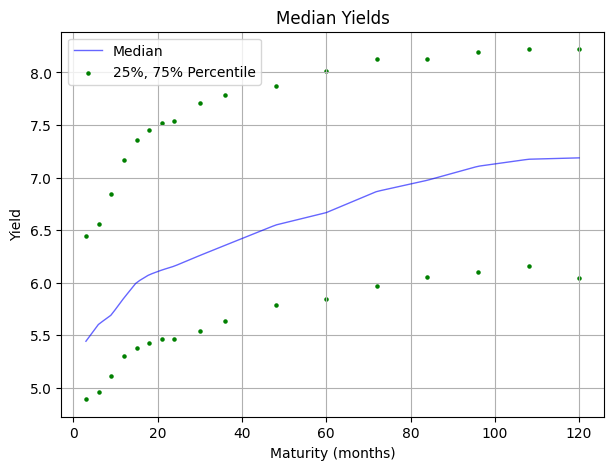

In [19]:
fig,ax = plt.subplots(figsize = (7, 5))


ax.plot(grid_median, y, label='Median',linestyle = '-', linewidth = 1, color = 'b', alpha = 0.6)
ax.scatter(int_columns, perc_25, label='25%, 75% Percentile',marker = '.',color = 'g', s = 20)
ax.scatter(int_columns, perc_75, marker = '.',color = 'g', s = 20)

ax.set_title('Median Yields')
ax.set_xlabel('Maturity (months)')
ax.set_ylabel('Yield')

ax.legend()
plt.grid()
#plt.savefig('figure3.png')
plt.show()

# Fitting the yield curve

In [20]:
#estimate a time series of beta1, beta2 and beta3

#create an empty matrix:
Betas = np.zeros((len(df),3))
residuals = np.zeros ((len(columns),len(df)))

#fill the matrix:
#each row contain the OLS estimates of the coefficient of the Nelson-Siegel curve

# for each index date:
# my y is the yield for each maturity 
# my x's are the facotor loadings (betas)

#each row of Beta contains the three betas for a certain date

for obs in range(len(df)):
    model = sm.OLS(df.iloc[obs,:], X)
    result = model.fit()
    Betas[obs,:] = np.array(result.params)
    residuals[:,obs] = np.array(result.resid)

Betas_frame = pd.DataFrame(Betas, index= df.index, columns = ['1', '2', '3'])

## Average

In [21]:
#average:
model_average = sm.OLS(mean[:-2], X)
result_average = model_average.fit()
print(result_average.params)

[ 7.58018749 -2.09885978 -0.16500668]


In [22]:
#now we need to fit the yields using the nelson-siegel formula for the mean yield and plot it with the actual mean
#we need to define a function that computes the neslson-siegel forward rate curve

def fitted_curve(params,maturities):
    '''
    Compute the Nelson-Siegel forward rate curve.
    params : np.array, OLS parameters (Betas)
    maturities : np.array, maturities of the bonds
    '''
    
    return params[0] + params[1]*(load2(maturities)) + params[2]*(load3(maturities))

In [23]:
fitted_mean = fitted_curve(result_average.params,time_to_mat)

## Figure 4

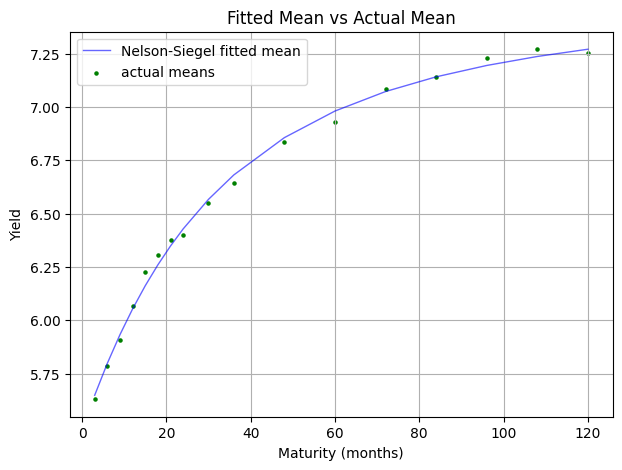

In [24]:
#plot the scatter of the mean and the fitted curve for the mean:
fig,ax = plt.subplots(figsize = (7, 5))

ax.plot(time_to_mat, fitted_mean, label='Nelson-Siegel fitted mean',linestyle='-', linewidth=1, color='b', alpha=0.6)
ax.scatter(time_to_mat, mean[:-2], label='actual means',marker='.',color='g', s=20)

ax.set_title('Fitted Mean vs Actual Mean')
ax.set_xlabel('Maturity (months)')
ax.set_ylabel('Yield')

ax.legend()
plt.grid()
#plt.savefig('figure4.png')
plt.show()

## Example: 4 plots

In [25]:
#get the indexes of the date:
index1 = df.index.get_loc(dt.datetime.strptime('1989-03-31', '%Y-%m-%d'))
index2 = df.index.get_loc(dt.datetime.strptime('1989-07-31', '%Y-%m-%d'))
index3 = df.index.get_loc(dt.datetime.strptime('1997-05-30', '%Y-%m-%d'))
index4 = df.index.get_loc(dt.datetime.strptime('1998-08-31', '%Y-%m-%d'))

#list of indexes
example_index = (index1, index2, index3, index4)

In [26]:
#fit the curve for each date:
fitted_example = np.zeros((4,len(df.columns)))

for i in range(len(example_index)):
    fitted_example[i,:] = fitted_curve(Betas[example_index[i],:],time_to_mat)    

## Figure 5

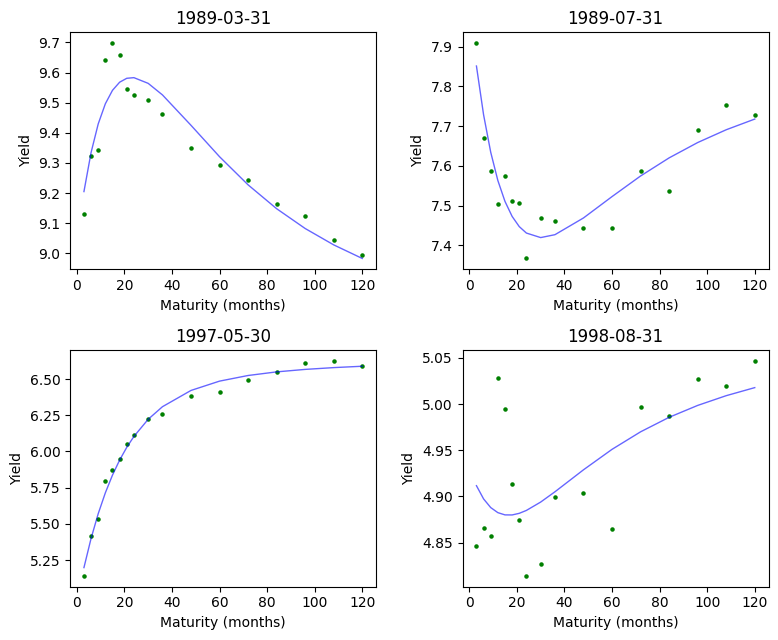

In [27]:
# Create a figure and 4 subplots arranged in 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(8, 6.5))

# Plot data on each subplot
axs[0, 0].plot(time_to_mat, fitted_example[0,:], linestyle='-', linewidth=1, color='b', alpha=0.6)
axs[0, 0].scatter(time_to_mat,df.iloc[index1], marker='.', color='g', s=20)
axs[0, 0].set_title('1989-03-31')
axs[0, 0].set_xlabel('Maturity (months)')
axs[0, 0].set_ylabel('Yield')

axs[0, 1].plot(time_to_mat, fitted_example[1,:], linestyle='-', linewidth=1, color='b', alpha=0.6)
axs[0, 1].scatter(time_to_mat,df.iloc[index2], marker='.', color='g', s=20)
axs[0, 1].set_title('1989-07-31')
axs[0, 1].set_xlabel('Maturity (months)')
axs[0, 1].set_ylabel('Yield')

axs[1, 0].plot(time_to_mat, fitted_example[2,:], linestyle='-', linewidth=1, color='b', alpha=0.6)
axs[1, 0].scatter(time_to_mat,df.iloc[index3], marker='.', color='g', s=20)
axs[1, 0].set_title('1997-05-30')
axs[1, 0].set_xlabel('Maturity (months)')
axs[1, 0].set_ylabel('Yield')

axs[1, 1].plot(time_to_mat, fitted_example[3,:], linestyle='-', linewidth=1, color='b', alpha=0.6)
axs[1, 1].scatter(time_to_mat,df.iloc[index4], marker='.', color='g', s=20)
axs[1, 1].set_title('1998-08-31')
axs[1, 1].set_xlabel('Maturity (months)')
axs[1, 1].set_ylabel('Yield')



# Adjust layout to prevent overlap of subplots
plt.tight_layout()

#plt.savefig('figure5.png')
plt.show()

## Betas vs level slope and curvature (Figure 6)

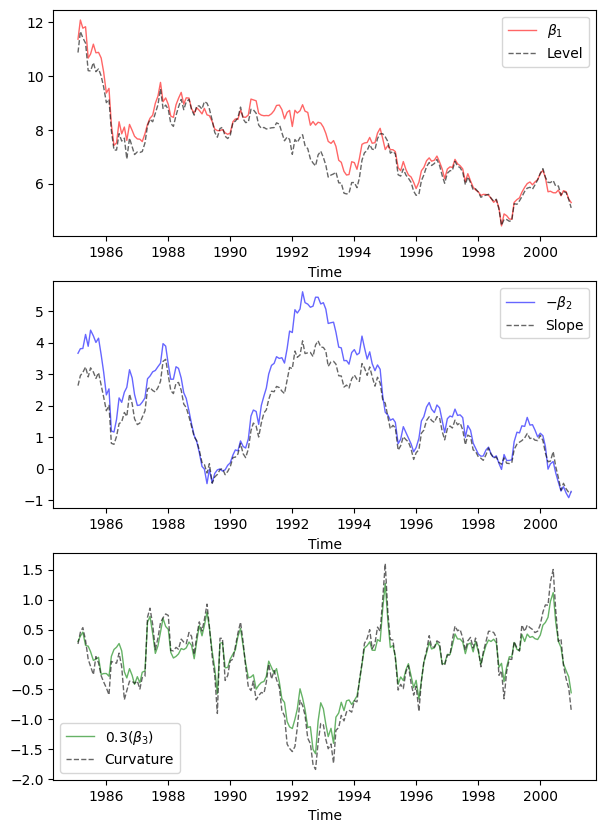

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(7, 10))

axs[0].plot(df.index, Betas[:,0], label=r'$\beta_1$', linestyle='-', linewidth=1, color='r', alpha=0.6)
axs[0].plot(df.index, df['120'], label='Level', linestyle='--', linewidth=1, color='black', alpha=0.6)
axs[0].set_xlabel('Time')
axs[0].legend()

axs[1].plot(df.index, -(Betas[:,1]), label=r'$-\beta_2$', linestyle='-', linewidth=1, color='b', alpha=0.6)
axs[1].plot(df.index, df1['Slope'], label='Slope', linestyle='--', linewidth=1, color='black', alpha=0.6)
axs[1].set_xlabel('Time')
axs[1].legend()

axs[2].plot(df.index, 0.3*(Betas[:,2]), label =r'$0.3(\beta_3)$' ,linestyle='-', linewidth=1, color='g', alpha=0.6)
axs[2].plot(df.index, df1['Curvature'], label='Curvature', linestyle='--', linewidth=1, color='black', alpha=0.6)
axs[2].set_xlabel('Time')
axs[2].legend()

#plt.savefig('figure6.png')
plt.show()

In [29]:
#correlation between estimated and empirical factors
corr = np.zeros((3,1))


#compute the correlation between the betas and the last three columns of df1 (level,slope,curvature)
for i in range(len(corr)):
    corr[i,0] = round(np.corrcoef(Betas[:,i],df1.iloc[:,-3+i])[0,1],2)

corr = pd.DataFrame(corr,index=[r'$\rho(\hat{\beta}_{1t},l_t)$',
                                r'$\rho(\hat{\beta}_{2t},s_t)$',
                                r'$\rho(\hat{\beta}_{3t},c_t)$'],
                   columns=[''])
corr
#print(corr.to_latex(float_format = '%.3f'))

,
"$\rho(\hat{\beta}_{1t},l_t)$",0.97
"$\rho(\hat{\beta}_{2t},s_t)$",-0.99
"$\rho(\hat{\beta}_{3t},c_t)$",0.99


## Residuals (Table 2)

In [30]:
#descriptive statistics of the residuals
res_mean = [round(residuals[i,:].mean(),3) for i in range(len(residuals))]

res_std_dev = [round(np.sqrt(np.var(residuals[i,:], ddof=1)),3) for i in range(len(residuals))]

res_min = [round(residuals[i,:].min(),3) for i in range(len(residuals))]

res_max = [round(residuals[i,:].max(),3) for i in range(len(residuals))]

mae = [round(np.mean(np.abs(residuals[i,:])),3) for i in range(len(residuals))]

rmse = [round(np.sqrt(np.mean(residuals[i,:]**2)),3) for i in range(len(residuals))]

res_ro_1 = [round(sm.tsa.acf(residuals[i,:], nlags=lags[0], fft=False)[lags[0]],3) for i in range(len(residuals))]

res_ro_12 = [round(sm.tsa.acf(residuals[i,:], nlags=lags[1], fft=False)[lags[1]],3) for i in range(len(residuals))]

res_ro_30 = [round(sm.tsa.acf(residuals[i,:], nlags=lags[2], fft=False)[lags[2]],3) for i in range(len(residuals))]

In [31]:
#collect the statistics in a list of lists:
res_data = [res_mean, res_std_dev, res_min, res_max, mae, rmse, res_ro_1, res_ro_12, res_ro_30]

#transpose the lists and create a nice table
res_data = list(map(list, zip(*res_data)))

#columns names
res_colnames = ['Mean', 'Std.Dev', 'Min', 'Max', 'MAE', 'RMSE',
                r'$\hat{\rho}$(1)', r'$\hat{\rho}$(12)', r'$\hat{\rho}$(30)']

#create the table
table2 = pd.DataFrame(res_data, index=columns, columns=res_colnames)
table2.head()
#print(table2.to_latex(float_format='%.3f'))

,Mean,Std.Dev,Min,Max,MAE,RMSE,$\hat{\rho}$(1),$\hat{\rho}$(12),$\hat{\rho}$(30)
3,-0.018,0.080,-0.332,0.156,0.061,0.082,0.778,0.157,-0.360
6,-0.013,0.042,-0.141,0.218,0.032,0.044,0.290,0.257,-0.046
9,-0.026,0.062,-0.201,0.218,0.052,0.067,0.704,0.216,-0.247
12,0.013,0.080,-0.160,0.267,0.064,0.081,0.562,0.321,-0.265
15,0.063,0.050,-0.063,0.242,0.067,0.080,0.650,0.139,-0.069


## Descriptive statistics of Betas (Table 3)

In [32]:
beta_mean = [round(np.mean(Betas[:,i]),3) for i in range(len(np.transpose(Betas)))]

beta_std_dev = [round(np.sqrt(np.var(Betas[:,i])),3) for i in range(len(np.transpose(Betas)))]

beta_min = [round(Betas[:,i].min(),3) for i in range(len(np.transpose(Betas)))]

beta_max = [round(Betas[:,i].max(),3) for i in range(len(np.transpose(Betas)))]

beta_ro_1 = [round(sm.tsa.acf(Betas[:,i], nlags=lags[0], fft=False)[lags[0]],3) for i in range(len(np.transpose(Betas)))]

beta_ro_12 = [round(sm.tsa.acf(Betas[:,i], nlags=lags[1], fft=False)[lags[1]],3) for i in range(len(np.transpose(Betas)))]

beta_ro_30 = [round(sm.tsa.acf(Betas[:,i], nlags=lags[2], fft=False)[lags[2]],3) for i in range(len(np.transpose(Betas)))]

beta_adf = [sm.tsa.adfuller(Betas[:,i], autolag='BIC', store=True)[0] for i in range(len(np.transpose(Betas)))]

In [33]:
#collect the statistics in a list of lists:
beta_data = [beta_mean, beta_std_dev, beta_min, beta_max, beta_ro_1, beta_ro_12, beta_ro_30, beta_adf]

#transpose the lists and create a nice table
beta_data = list(map(list, zip(*beta_data)))

#columns names
beta_colnames = ['Mean', 'Std.Dev', 'Min', 'Max', r'$\hat{\rho}$(1)', r'$\hat{\rho}$(12)', r'$\hat{\rho}$(30)', 'ADF']

#create an index
beta_index = [r'$\hat{\beta}_{1t}$', r'$\hat{\beta}_{2t}$', r'$\hat{\beta}_{3t}$']

#create the table
table3 = pd.DataFrame(beta_data, index=beta_index, columns=beta_colnames)
table3
#print(table3.to_latex(float_format = '%.3f'))

,Mean,Std.Dev,Min,Max,$\hat{\rho}$(1),$\hat{\rho}$(12),$\hat{\rho}$(30),ADF
$\hat{\beta}_{1t}$,7.580,1.520,4.427,12.089,0.957,0.511,0.454,-2.133352
$\hat{\beta}_{2t}$,-2.099,1.604,-5.616,0.919,0.969,0.452,-0.082,-1.337617
$\hat{\beta}_{3t}$,-0.164,1.681,-5.251,4.233,0.901,0.354,-0.007,-3.542007


# Forecast

In [34]:
#retrieve the time series of estimated factors form the Betas matrix
beta1 = Betas[:,0]
beta2 = Betas[:,1]
beta3 = Betas[:,2]

### AR(1) on Betas:

In [35]:
#fitting an AR(1) model for beta1, beta2 and beta3:
beta1ar = ARIMA(beta1, order=(1,0,0), trend='c')
beta1ar_fit = beta1ar.fit()

beta2ar = ARIMA(beta2, order=(1,0,0), trend='c')
beta2ar_fit = beta2ar.fit()

beta3ar = ARIMA(beta3, order=(1,0,0), trend='c')
beta3ar_fit = beta3ar.fit()

### Autocorrelation of factors and AR(1) residuals (figure 8)

In [36]:
#compute acf for betas and residuals of AR(1) regression
beta1_acf = sm.tsa.acf(beta1, nlags=60, fft=False)
res_beta1ar_acf = sm.tsa.acf(beta1ar_fit.resid, nlags=60, fft=False)
res_beta1ar_acf = res_beta1ar_acf[1:]

beta2_acf = sm.tsa.acf(beta2, nlags=60, fft=False)
res_beta2ar_acf = sm.tsa.acf(beta2ar_fit.resid, nlags=60, fft=False)
res_beta2ar_acf = res_beta2ar_acf[1:]

beta3_acf = sm.tsa.acf(beta3, nlags=60, fft=False)
res_beta3ar_acf = sm.tsa.acf(beta3ar_fit.resid, nlags=60, fft=False)
res_beta3ar_acf = res_beta3ar_acf[1:]

## Figure 7

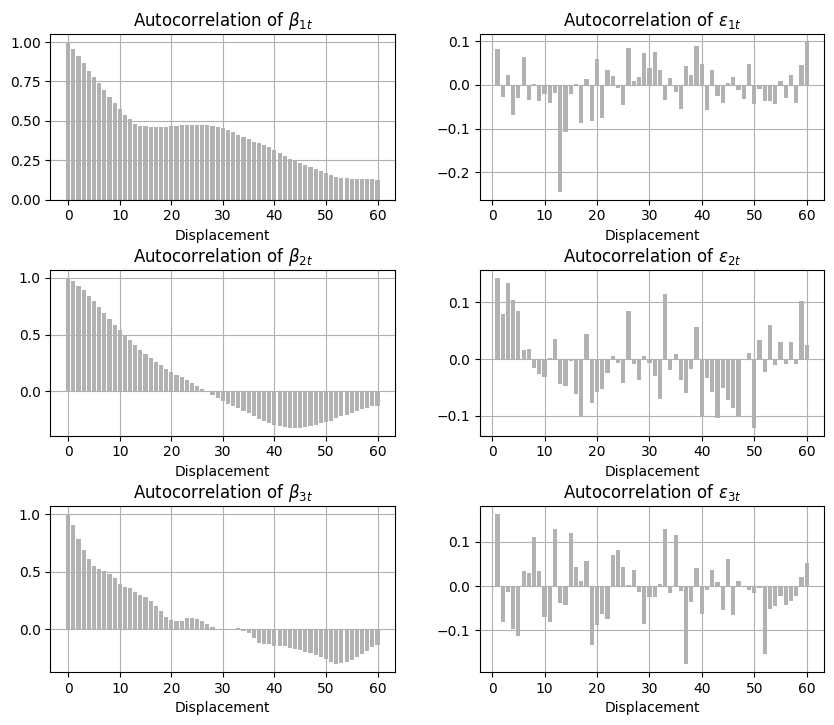

In [37]:
displacement = range(0,61)
displacement_res = range(1,61)

fig, axs = plt.subplots(3,2, figsize=(9, 7.5))
fig.tight_layout(pad=3)

axs[0,0].bar(displacement, beta1_acf, color='gray', alpha=0.6)
axs[0,1].bar(displacement_res, res_beta1ar_acf, color='gray', alpha=0.6)
                                                    
axs[1,0].bar(displacement, beta2_acf, color='gray', alpha=0.6)
axs[1,1].bar(displacement_res, res_beta2ar_acf, color='gray', alpha=0.6)
axs[2,0].bar(displacement, beta3_acf, color='gray', alpha=0.6)
axs[2,1].bar(displacement_res, res_beta3ar_acf, color='gray', alpha=0.6)

axs[0,0].set_title(r'Autocorrelation of $\beta_{1t}$')
axs[0,1].set_title(r'Autocorrelation of $\epsilon_{1t}$')
axs[1,0].set_title(r'Autocorrelation of $\beta_{2t}$')
axs[1,1].set_title(r'Autocorrelation of $\epsilon_{2t}$')
axs[2,0].set_title(r'Autocorrelation of $\beta_{3t}$')
axs[2,1].set_title(r'Autocorrelation of $\epsilon_{3t}$')

axs[0,0].set_xlabel('Displacement')
axs[0,1].set_xlabel('Displacement')
axs[1,0].set_xlabel('Displacement')
axs[1,1].set_xlabel('Displacement')
axs[2,0].set_xlabel('Displacement')
axs[2,1].set_xlabel('Displacement')

axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

#plt.savefig('figure7.png')
plt.show()

## Forecasting models

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
def NSForecastModel(method, h):
    '''
    Perform AR(1) or VAR(1) h-step ahead out of sample prediction on NS loadings and compute the 
    yields with the forecasted loadings.
    method: string, AR or VAR
    h: integer, forecast steps
    '''
    #set names for data and index 
    data = df
    rownames = data.index
    #Betas already computed with OLS
    Betas = Betas_frame
    #forecast maturities
    forecast_mat = [3,12,36,60,120]
    #start date for the forecast ()
    index = np.where(rownames=='1993-12-31')[0][0]
    #initialize a matrix for the forcasts
    beta_forecast = np.zeros((len(rownames[index+h:,]),Betas.shape[1]))
    #true yileds from index+h to the end, considering only the maturities for the forecast
    true_y = data.iloc[index+h:,][['3','12','36','60','120']]
    
    if method == 'AR':
        #iterate by column:
        for j in range(0,Betas.shape[1]):
            #iterate by index(date):
            for i in range(0,beta_forecast.shape[0]):
                #estimate the AR model:
                model = ARIMA(Betas.iloc[:index+i+1,j], order=(1,0,0),trend='c')
                model_fit = model.fit()
                prediction = model_fit.forecast(steps=h)
                #store the forecasted beta:
                beta_forecast[i,j] = prediction.iloc[h-1]
    if method == 'VAR':
        #iterate by index(date):
        for i in range(0,beta_forecast.shape[0]):
            #estimate the VAR model:
            model = VAR(Betas.iloc[:index+i+1,:])
            model_fit = model.fit(maxlags=1)
            #store the forecasted beta:
            beta_forecast[i,:] = model_fit.forecast(model_fit.model.endog, steps=h)[h-1]
    
    #transform the matrix with forecasted betas in a dataframe:
    beta_forecast = pd.DataFrame(beta_forecast, index=rownames[index+h:], columns=Betas.columns)
    
    #initialize a matrix for storing the fitted NS yields:
    ns_pred=np.zeros((len(rownames[index+h:]), len(forecast_mat)))
    #compute the Nelson Siegel fitted yields:
    for i in range(0,beta_forecast.shape[0]):
        ns_pred[i,:] = fitted_curve(beta_forecast.iloc[i,:],np.array(forecast_mat))
    #transform the matrix in a nice dataframe:    
    ns_pred = pd.DataFrame(ns_pred, index=rownames[index+h:], columns=['3','12','36','60','120'])
    #return true values and the NS fitted yields with predicted Betas:
    return true_y, ns_pred
    

In [40]:
def ForecastModel(method, h):
    '''
    Perform AR(1) or VAR(1) h-step ahead out of sample forecast directly on yields
    method: string, AR or VAR
    h: int, forecast steps
    '''
    #set names for data and index 
    data = df[['3','12','36','60','120']]
    rownames = data.index
    #forecast maturities
    forecast_mat = [3,12,36,60,120]
    #start date for the forecast ()
    index = np.where(rownames=='1993-12-31')[0][0]
    #initialize a matrix for the forcasts
    y_forecast = np.zeros((len(rownames[index+h:,]),len(forecast_mat)))
    #true yileds from index+h to the end, considering only the maturities for the forecast
    true_y = data.iloc[index+h:,][['3','12','36','60','120']]
    
    if method == 'AR':
        #iterate by column:
        for j in range(0, len(forecast_mat)):
            #iterate by index:
            for i in range(0, y_forecast.shape[0]):
                #estimate the AR model:
                model = ARIMA(data.iloc[:index+i+1,j], order=(1,0,0), trend='c')
                model_fit = model.fit()
                prediction = model_fit.forecast(steps=h)
                #store the forecasted yield:
                y_forecast[i,j] = prediction.iloc[h-1]
                
    if method == 'VAR':
        #iterate by index:
        for i in range(0, y_forecast.shape[0]):
            #estimate the VAR model:
            model = VAR(data.iloc[:index+i+1,])
            model_fit = model.fit(maxlags=1)
            y_forecast[i,:] = model_fit.forecast(model_fit.endog, steps=h)[h-1]
    
    #transform the matrix in a nice dataframe:
    y_pred = pd.DataFrame(y_forecast, index=rownames[index+h:], columns=['3','12','36','60','120'])
    #return true values and forecasted values
    return true_y, y_pred

In [41]:
def RandomWalk(h):
    '''
    Perform a h-steps ahead random walk forecast
    h: int, forecast steps
    '''
    #set names for data and index 
    data = df[['3','12','36','60','120']]
    rownames = data.index
    #forecast maturities
    forecast_mat = [3,12,36,60,120]
    #start date for the forecast ()
    index = np.where(rownames=='1993-12-31')[0][0]
    #initialize a matrix for the forcasts
    rw_forecast = np.zeros((len(rownames[index+h:,]),len(forecast_mat)))
    #true yileds from index+h to the end, considering only the maturities for the forecast
    true_y = data.iloc[index+h:,][['3','12','36','60','120']]
    
    #Random walk forecast is just the last available value:
    #iterate by index:
    for i in range(0, rw_forecast.shape[0]):
        train = data.iloc[:index+1+i,:]
        rw_forecast[i,:] = train.iloc[-1,:]
    
    #tranform the matrix in a nice dataframe:
    rw_pred = pd.DataFrame(rw_forecast, index=rownames[index+h:], columns=['3','12','36','60','120'])
    #reurn true values and forecasted values
    return true_y, rw_pred

## Compute forecasts (this part may take some time to run)

In [42]:
#Nelson-Siegel factors forecast
#AR(1)
nsar1 = NSForecastModel(method='AR', h=1)
nsar6 = NSForecastModel(method='AR', h=6)
nsar12 = NSForecastModel(method='AR', h=12)
#VAR(1)
nsvar1 = NSForecastModel(method='VAR', h=1)
nsvar6 = NSForecastModel(method='VAR', h=6)
nsvar12 = NSForecastModel(method='VAR', h=12)

In [43]:
#Direct forecast
#AR(1)
ar1 = ForecastModel(method='AR', h=1)
ar6 = ForecastModel(method='AR', h=6)
ar12 = ForecastModel(method='AR', h=12)
#VAR(1)
var1 = ForecastModel(method='VAR', h=1)
var6 = ForecastModel(method='VAR', h=6)
var12 = ForecastModel(method='VAR', h=12)

In [44]:
#Random walk
rw1 = RandomWalk(h=1)
rw6 = RandomWalk(h=6)
rw12 = RandomWalk(h=12)

### Descriptive statistics of forecast errors

In [45]:
def forecast_descr_stats(true, forecast, h):
    '''
    Compute the forecast error and some descriptive statistics
    true: dataframe containing the true values
    forecast: dataframe containing the forecasted values
    h: int, forecast steps
    '''
    #initialize a matrix to store the statistics
    stats = np.zeros((len(true.columns),5))
    #compute the error 
    a=true-forecast
    #define the index (maturities)
    maturities = [
        '3 months',
        '1 year',
        '3 years',
        '5 years',
        '10 years'
    ]
    #iterate by column:
    for col in range(0, len(a.columns)):
        #compute the statistics:
        mean = np.mean(a.iloc[:,col])
        std = np.std(a.iloc[:,col])
        mse = np.mean(a.iloc[:,col]**2)
        rmse = np.sqrt(mse)
        corr1 = sm.tsa.acf(a.iloc[:,col], nlags=h, fft=False)[h]
        ro = r'$\hat{\rho}$' 
        if h==1: 
            corr12 = sm.tsa.acf(a.iloc[:,col], nlags=h+12, fft=False)[h+11]
            columns = ['Mean', 'Std', 'RMSE', f'{ro}({h})', f'{ro}({h+11})']
        else: 
            corr12 = sm.tsa.acf(a.iloc[:,col], nlags=h+12, fft=False)[h+12]
            columns = ['Mean', 'Std', 'RMSE', f'{ro}({h})', f'{ro}({h+12})']
        
        #round by 3 digits and store the statistics in a matrix
        stats[col,0] = round(mean, 3)                                         
        stats[col,1] = round(std, 3)
        stats[col,2] = round(rmse, 3)
        stats[col,3] = round(corr1, 3)
        stats[col,4] = round(corr12, 3)
     
    #transform the matrix in a nice dataframe:
    descr_stats = pd.DataFrame(stats, index = maturities, columns=columns)
    #return the dataframe containing all the descriptive statistics of the forecast error
    return descr_stats

In [46]:
#Forecast error descriptive statistics
#N-S
stats_nsar1 = forecast_descr_stats(nsar1[0], nsar1[1], h=1)
stats_nsar6 = forecast_descr_stats(nsar6[0], nsar6[1], h=6)
stats_nsar12 = forecast_descr_stats(nsar12[0], nsar12[1], h=12)

stats_nsvar1 = forecast_descr_stats(nsvar1[0], nsvar1[1], h=1)
stats_nsvar6 = forecast_descr_stats(nsvar6[0], nsvar6[1], h=6)
stats_nsvar12 = forecast_descr_stats(nsvar12[0], nsvar12[1], h=12)

#Direct
stats_ar1 = forecast_descr_stats(ar1[0], ar1[1], h=1)
stats_ar6 = forecast_descr_stats(ar6[0], ar6[1], h=6)
stats_ar12 = forecast_descr_stats(ar12[0], ar12[1], h=12)

stats_var1 = forecast_descr_stats(var1[0], var1[1], h=1)
stats_var6 = forecast_descr_stats(var6[0], var6[1], h=6)
stats_var12 = forecast_descr_stats(var12[0], var12[1], h=12)

#Random walk
stats_rw1 = forecast_descr_stats(rw1[0], rw1[1], h=1)
stats_rw6 = forecast_descr_stats(rw6[0], rw6[1], h=6)
stats_rw12 = forecast_descr_stats(rw12[0], rw12[1], h=12)

## Table (4-5-6)

In [47]:
#type the name of any of the variables above that begin with 'stats_' and obtain the table with the descriptive
#statistics of the forecast error of the desired model and forecast horizon

#Example:
stats_rw12

,Mean,Std,RMSE,$\hat{\rho}$(12),$\hat{\rho}$(24)
3 months,0.292,0.892,0.938,-0.240,-0.055
1 year,0.177,1.004,1.020,-0.372,0.004
3 years,0.012,1.078,1.078,-0.460,0.024
5 years,-0.075,1.070,1.072,-0.477,0.006
10 years,-0.198,0.965,0.985,-0.467,-0.029


### Diebold-Mariano test

In [48]:
def dieboldmariano(true,forecast1,forecast2, models):
    '''
    Perform Diebold-Mariano test on the out-of-sample accuracy of forecast between two different models.
    true: pd.Series, true values
    forecast1: pd.Series, first model forecasted values
    forecast2: pd.Series, second model forecasted values
    models: list of strings, names of the two models
    '''
    #define the maturity for which perform the test:
    forecast_mat = ['3','12','36','60','120']
    #initialize a matrix to store the results:
    test_table = np.zeros((len(forecast_mat), 2))
    #iterate by column, compute the test for each maturity:
    for j in range(len(forecast_mat)):
        test = dm_test(true.iloc[:,j],forecast1.iloc[:,j],forecast2.iloc[:,j])
        #store the results:
        test_table[j,:] = test
    
    #define the indexes and the columns of the table:
    indexes = ['3 months', '1 year', '3 years', '5 years' , '10 years']
    columns = [f'{models[0]} vs {models[1]}', 'p-value']
    #transform the matrix with the result in a nice dataframe:
    test_table = pd.DataFrame(test_table, index=indexes, columns=columns)
    return test_table

In [49]:
#test for 1-month ahead forecast vs random walk 
one_month_test_rw = dieboldmariano(nsar1[0], nsar1[1], rw1[1], models=['N-S AR(1)', 'Random Walk'])

#test for 1-month ahead forecast vs direct AR(1)
one_month_test_ar = dieboldmariano(nsar1[0], nsar1[1], ar1[1], models=['N-S AR(1)', 'AR(1) on yield levels'])


# test for 12-months ahead forecast vs random walk
twelve_months_test_rw = dieboldmariano(nsar12[0], nsar12[1], rw12[1], models=['N-S AR(1)', 'Random Walk'])

# test for 12-months ahead forecast vs direct AR(1)
twelve_months_test_ar = dieboldmariano(nsar12[0], nsar12[1], ar12[1], models=['N-S AR(1)', 'AR(1) on yield levels'])


## Table 7

In [50]:
#diebold-mariano test N-S AR(1) vs RW:
table7 = [one_month_test_rw, twelve_months_test_rw]
table7 = pd.concat(table7, axis=1, join='outer')
table7
#print(table7.to_latex(float_format='%.3f'))

,N-S AR(1) vs Random Walk,p-value,N-S AR(1) vs Random Walk,p-value
3 months,-1.611003,0.110976,-2.288570,0.025041
1 year,-0.811859,0.419195,-2.196271,0.031294
3 years,-1.078132,0.284098,-2.093403,0.039836
5 years,0.670616,0.504327,-0.939581,0.350574
10 years,0.033738,0.973167,0.953866,0.343343


In [51]:
#diebold-mariano test N-S AR(1) vs direct AR(1):
table8 = [one_month_test_ar, twelve_months_test_ar]
table8 = pd.concat(table8, axis=1, join='outer')
table8
#print(table8.to_latex(float_format='%.3f'))

,N-S AR(1) vs AR(1) on yield levels,p-value,N-S AR(1) vs AR(1) on yield levels,p-value
3 months,-1.437412,0.154360,-1.540987,1.277038e-01
1 year,-0.388458,0.698672,-1.333878,1.864478e-01
3 years,-1.394098,0.167009,-2.709663,8.412122e-03
5 years,0.891909,0.375020,-3.384740,1.156373e-03
10 years,-0.432206,0.666713,-5.605344,3.598558e-07
